# Assignment 1 – Practical Deep Learning Workshop

We decided to select the dog-breed-identification Dataset. We will have to determine the breed of a dog in an image, out of 120 different breeds. All images are taken from the ImageNet dataset; i.e., this dataset is a strict subset of ImageNet.

1)	Exploratory data analysis of the dataset that we selected:

a.	The size of the dataset is 10222 samples. We've run a corresponding script which divided the images into 120 folders which represent each class. 

b.	The data each sample contains:

The dimensions of the data samples in this dataset vary. All the samples are colored so they have 3 channels (RGB).
We can see that the dimensions of each sample are different so it's not really ready for use. Therofore, we will need to preproccess the dateset and change the dimensions to some default size, or either create a model that is able to handle this variety.

We also see that the samples contain some noise, which is expressed in other artifacts in the images (a human next to a dog, trees, etc.). We can address that by excluding some 'bad' samples, as it's important to have high quality samples in the dataset to get good results. 

Having a large dataset is crucial for good performance. We see that we only have 10222 samples, a relatively small amount considering the fact that we need to clasify these samples into 120 classes.  
In order to get more data samples, we will use augmentation and make minor alterations to our existing dataset. Minor changes such as flips, translations or rotations.

We used the following kinds of augmentation, which we decided would be valid for our task:

Flip: we can flip the images horizontally. Doing this will not change the image perception, as the images will just face the other side.

Rotation: we can rotate the images in various angles. One key thing to note is that image dimensions may not be preserved after rotation. We will address it by filling the points outside the boundaries of the input.

Zoom: We can zoom randomly inside images or randomly translate images vertically and horizontally, within a specific range. 

Shear: We can also apply shearing transformations and change some graphics into something else by applying rules.

In order to understand how our augmentation method is changing our data we decided to create some images and explore the changes it added to the original image.

In [1]:
#testing imageGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
)
#loading image
img = load_img('../DogBreedDataSet/train/vizsla/0c4ac597d196aaf07f3af039b8fd6925.jpg')  # this is a PIL image
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the save_to_dir directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='AugmentedVizsla', save_prefix='augmentedVizsla', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Using TensorFlow backend.


Here are all the images that were created using our generator and a Vizsla dog model.

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


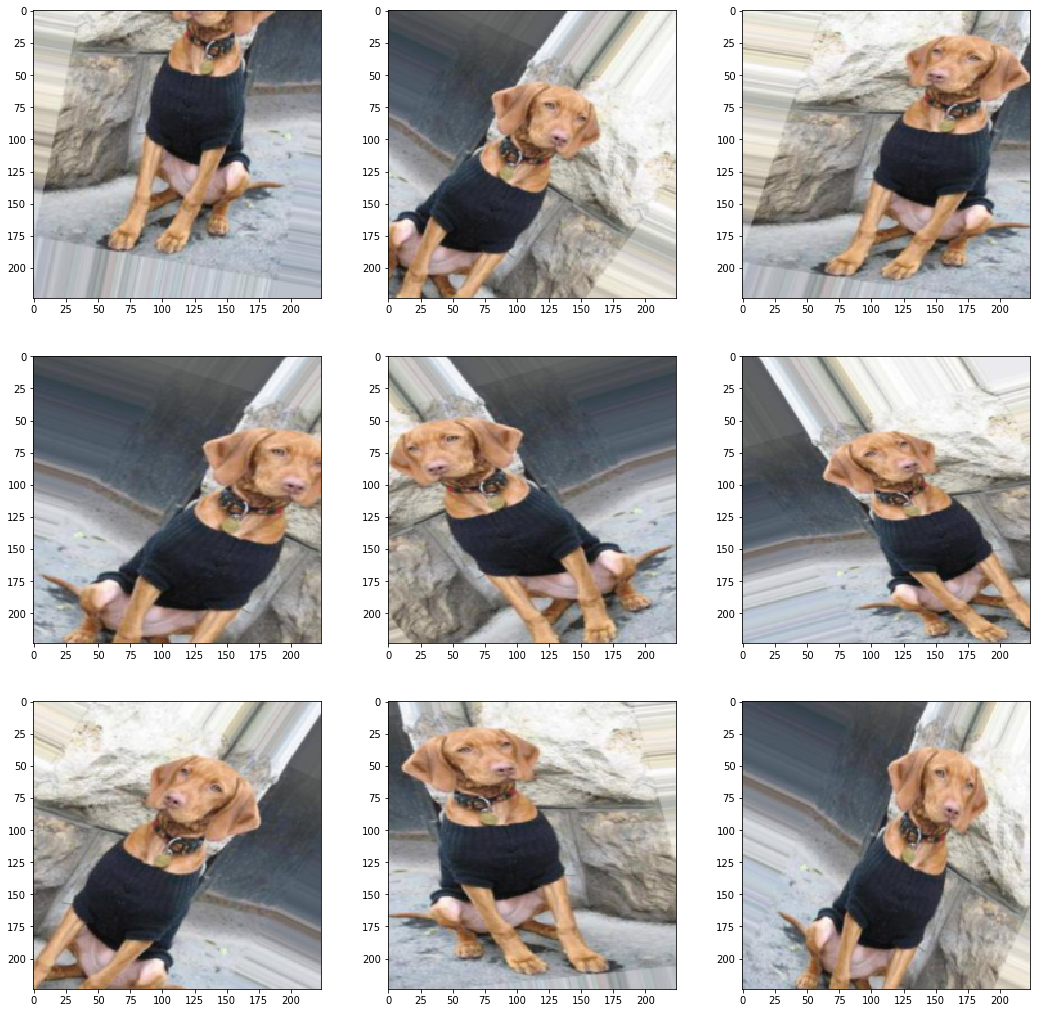

In [3]:
%matplotlib inline
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_imgs(data,nrows=4,ncols=4,figsize=(18,18)):
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    for i in range(nrows*ncols):
        ax[i%nrows,i//nrows].imshow(data[i])

def read_and_resize_single_img(filename,nrow=224,ncol=224,channels=3):
    from scipy import misc
    arr = misc.imread(filename)
    arr = misc.imresize(arr,size=(nrow,ncol,channels))
    return arr
 
viszlasArray = np.zeros((36,224,224,3))
i=0
for f in os.listdir(".\AugmentedVizsla"):
    arr=read_and_resize_single_img(f'.\AugmentedVizsla\{f}')
    if len(arr.shape)<3: arr = np.stack([arr,arr,arr],axis=-1) #change to use np.repeat() for more generalizable
    viszlasArray[i] = np.float16(arr)
    i+=1
    # breaking so id theres more images in augmented folder our array will not flow out of bound
    if i==35:
        break;

plot_multiple_imgs(viszlasArray/255,3,3)

c. We would like to check how many samples there are from each of the 120 classes in order to understand if the data is balanced. We'll see below a histogram of the dog breeds and the distribution of the samples over the target 120 classes:  

In [67]:
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML

%matplotlib inline

In [2]:
import pandas as pd
tr_data = pd.read_csv('../labels.csv')

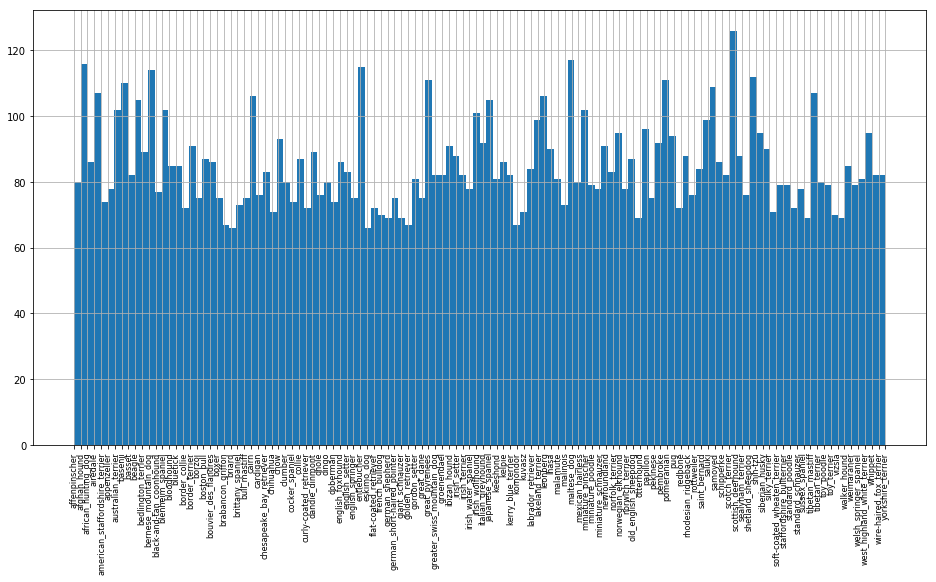

In [5]:
# Use the built-in DataFram function `hist` to plot a histogram of the dog breeds.
hist = tr_data['breed'].hist(figsize=(16, 8), bins=120, xrot=90, xlabelsize=8)
plt.show()

In [3]:
print('The sample count of each of the target classes is:')
print(tr_data.iloc[:,-1].value_counts())

The sample count of each of the target classes is:
scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
miniature_pinscher                102
blenheim_spaniel                  102
australian_terrier                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
norwegian_elkhound                 95
siberian_husky                     95

We see that the data is not balanced well. Every class has a different amount of samples, which varies between 66 and 126 samples per class. 

d. Benchmark results for different methods used on this data:

Convolutional neural network is by all accounts the best machine learning model for image classification, but in this case, there are not enough training examples to train it. It would not be able to learn generic enough patterns off this dataset to classify different dog breeds. Most likely, it will just overfit to this small amount of training examples so that accuracy on the test set will be low.

There are two possible approaches to address this:

-Merge dogs dataset with another bigger dataset with images and train a CNN on these merged examples.
This approach has two big downsides: a much bigger amount of data has to be analyzed and the training on this big dataset will take much more time and resources.

-Take an already pre-trained deep neural network on a larger dataset, cut into it, and attach an additional “classification head” i.e. several additional fully connected layers with the Softmax layer on top of them.


Almost every approach emphasized that the original ImageNet set has quite a few different dog classes so it's recommended to reuse CNNs with pretrained ImageNet weights. This way the prediction is much faster (<1s/image) making it possible to run meaningful experiments.
It appears that with modern machine learning frameworks (like TensorFlow) and pre-trained models for image recognition, the task could be solved with a pretty good accuracy without applying too many efforts and spending too much time and resources.

Here is a specific approach example, reusing CNN with pretrained weights:
An image is fed into Inception model. The output from Inception model goes through several fully connected (FC) layers, and finally the softmax outputs probabilities of an image to belong to each class. Inception model remains frozen with already predefined model parameters.
After executing 5K epochs, the metrics had the following values, when both errors pretty low on both test and training set:
cost = 0.1
Test Error = 2.7%
Train Error = 2.5%

Some other pre-trained deep neural network that may be used:
resnet50, vgg16, xception, inception resnet, inception v3

Below we can see the public leader board of the Kaggle competition, while the score column reffers to the multiclass loss:

Populating the interactive namespace from numpy and matplotlib


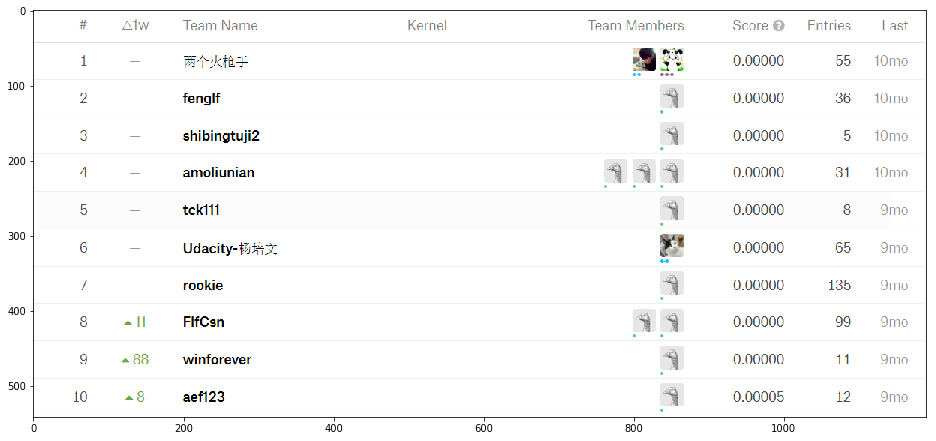

In [16]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(16,9))
img=mpimg.imread('.\pics\KaggleLeaderBoard.PNG')
imgplot = plt.imshow(img)
plt.show()

In addittion, most of the approaches we saw, encourage preproccessing the samples in order to improve the training proccess. 

e.	Show some samples from each label (if there are many categories try and present examples of easily separable ones vs. harder more similar categories)



Here we can see some examples from similar categories which are hard to separate:

### Siberian Husky:

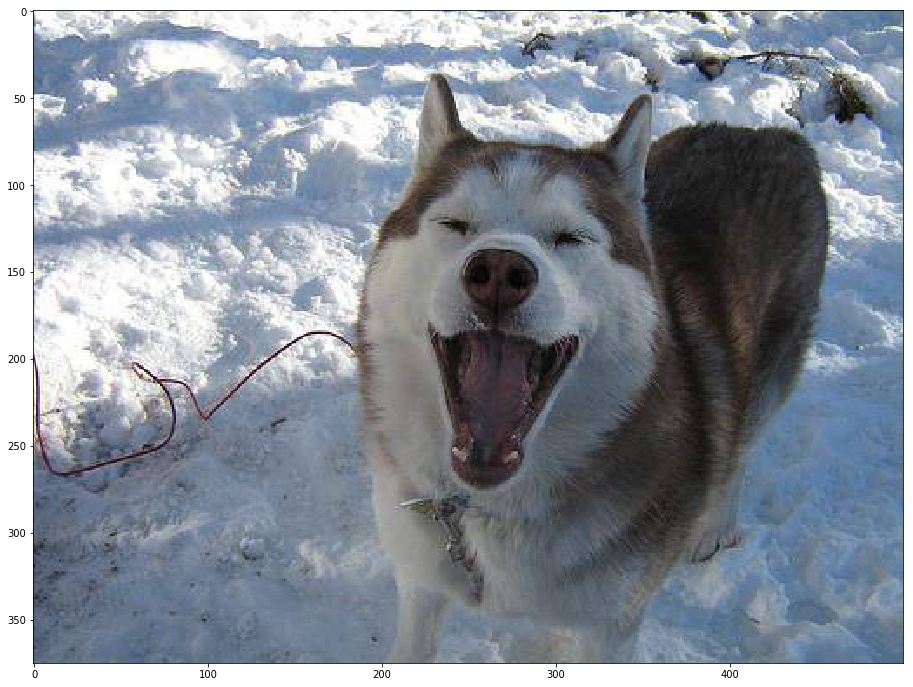

In [10]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/siberian_husky/7972d0467f6a8d6f209f948347061e24.jpg')
imgplot = plt.imshow(img)
plt.show()


## Eskimo Dog:

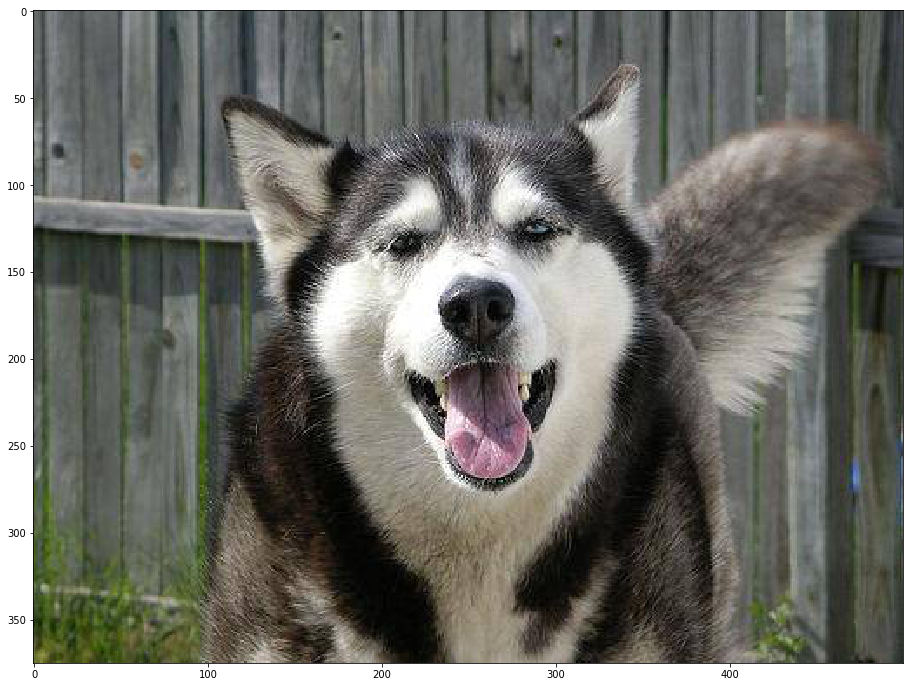

In [11]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/eskimo_dog/c9579c8fd920a1e698c696168946a83b.jpg')
imgplot = plt.imshow(img)
plt.show()


### Malamute:

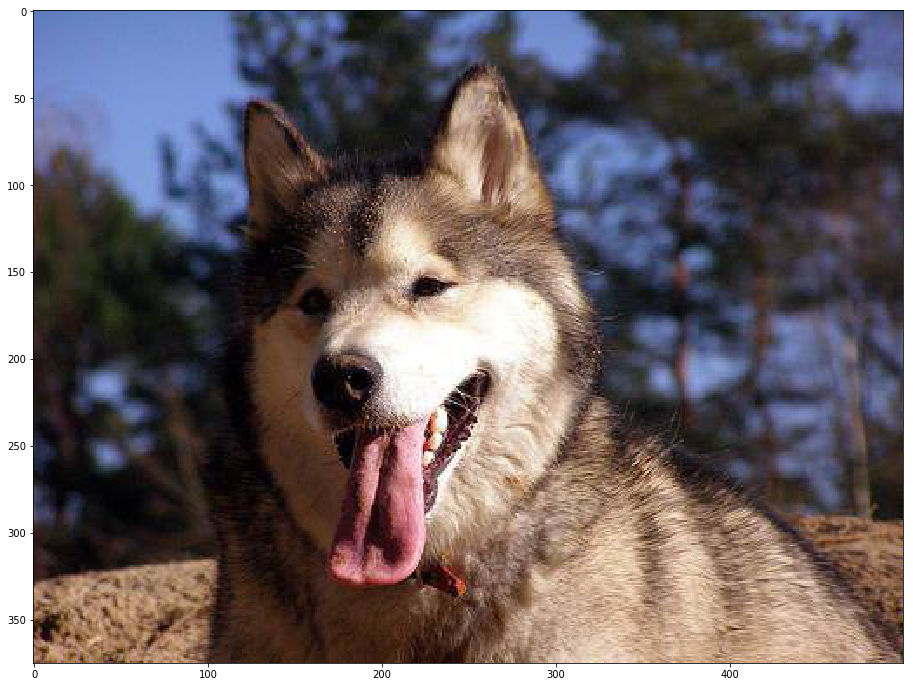

In [12]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/malamute/ed1957de19321d3f09348c0c1e3321a8.jpg')
imgplot = plt.imshow(img)
plt.show()


And on the other hand here are some examples from very different categories which are much more easier to separate:

### Boxer:

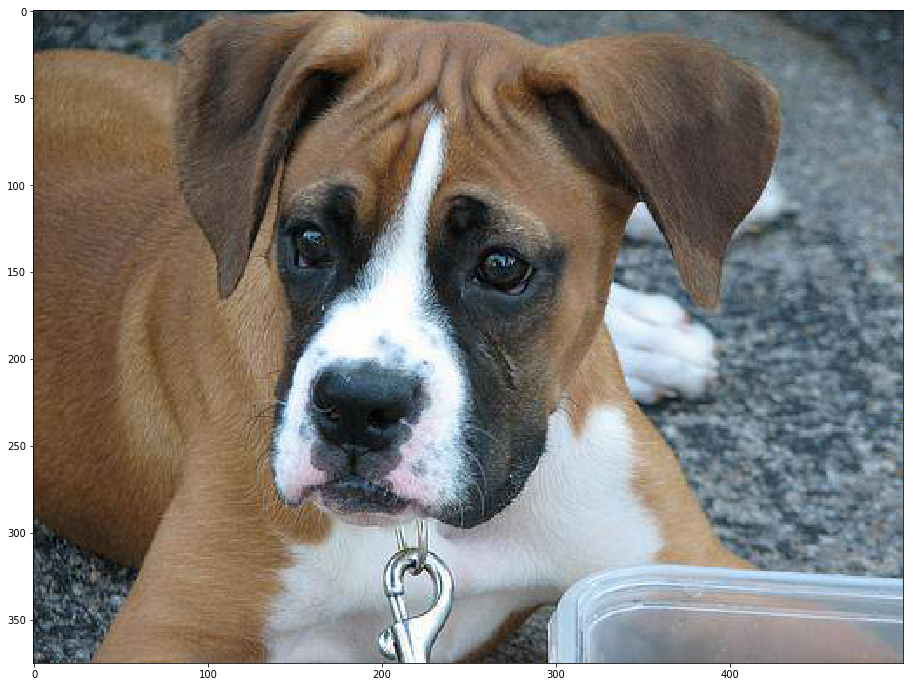

In [14]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/boxer/39eb055caee27cc3110ad26459fb64f9.jpg')
imgplot = plt.imshow(img)
plt.show()


### Afghan Hound:

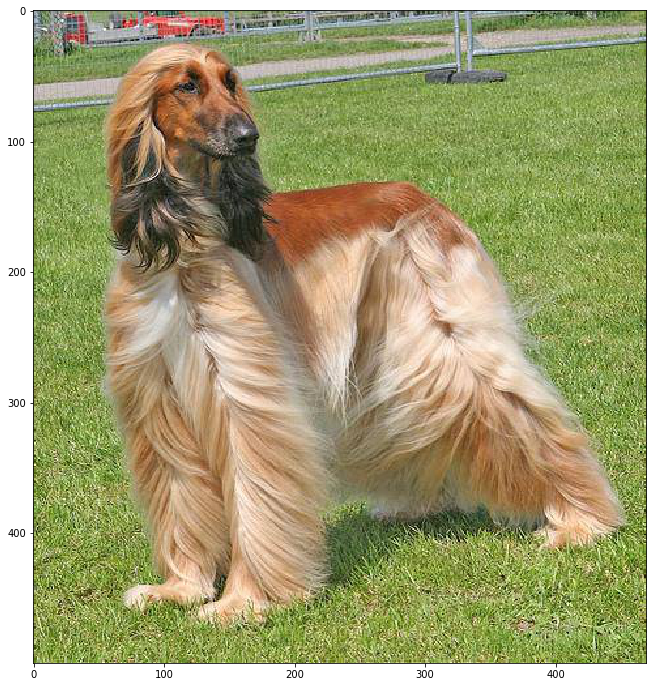

In [13]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/afghan_hound/2a59a96ffbdd6c8ba70465e3a7e10a3c.jpg')
imgplot = plt.imshow(img)
plt.show()


# Part 2

First of all, in order to create a graph for the data we need to convert all images to the same dimensions
All images are taken from the ImageNet dataset, hence we can use similar convertion techniques and expect good results.

a. Decide your validation strategy for training your model:

We created a Validation Dataset by chosing randomly 20% samples of data of each class, in order to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

b.	Fitting the model to the data and analyzing the results (Using visualizations to present loss and other metrics, showing examples for good and bad classification with high probability, and referring to the uncertain predictions.  
Comparing the results we got on the training data vs. the results for the validation/test data)

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint

import keras.backend as K
K.set_image_data_format('channels_last')

# dimensions of our images.
img_width, img_height = 224,224


train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
nb_train_samples = 8178
nb_validation_samples = 2044
epochs = 10
batch_size = 20

input_shape = (img_width, img_height, 3)
    
print("input_shape:",input_shape)

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(120, activation='softmax'))

model.summary()

input_shape: (224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 54, 54, 32)  

## A few words about the structure:

We used BatchNormalization, 5 blocks with Conv2D, MaxPooling2D and BatchNormalization layers, and a GlobalAveragePooling2D and Dense at last.

We normalize the input layer by adjusting and scaling the activations. Also, batch normalization allows each layer of a network to learn by itself a little bit more independently of other layers.
It also reduces overfitting because it has regularization effects.




## Compiling the model:

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        featurewise_center=True,
        featurewise_std_normalization=True
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    
)


# for validation we will use only rescaling
test_datagen = ImageDataGenerator(featurewise_center=True,
        featurewise_std_normalization=True)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

from time import gmtime, strftime
time = strftime("%Y.%m.%d.%H%M%S", gmtime())

tensor_board = TensorBoard(f'./logs/DogBreedAnn{time}')

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.bestaugmented.from_scratchT{time}.hdf5', 
                               verbose=1, save_best_only=True)



Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


# Training model in Increasing batches 

After a couple of tries we decided to train our model in increased batches, we expect it to first learn big differences between breeds and then with bigger batches generalize more

We also added ModelCheckpoint here so between runs we will take the best model and not the overfitted one

In [ ]:
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

## more training...

In [8]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 20
epochs = 5

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/5
408/408 [==============================] - 176s 432ms/step - loss: 3.0810 - acc: 0.2522 - val_loss: 3.5542 - val_acc: 0.1887

Epoch 00001: val_loss improved from 3.58153 to 3.55422, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/5
408/408 [==============================] - 173s 424ms/step - loss: 2.9910 - acc: 0.2667 - val_loss: 3.4592 - val_acc: 0.2085

Epoch 00002: val_loss improved from 3.55422 to 3.45920, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 3/5
408/408 [==============================] - 173s 424ms/step - loss: 2.9084 - acc: 0.2900 - val_loss: 3.6599 - val_acc: 0.1877

Epoch 00003: val_loss did not improve from 3.45920
Epoch 4/5
408/408 [==============================] - 178s 435ms/step - loss: 2.8280 - acc: 0.3059 - val_loss: 3.5285 - val_acc: 0.1966

Epoch 00004: val_loss did not improve from 3.45920
Epoch 5/5
408/408 [==============================] - 167s 409ms/step - loss: 2.7512 - acc: 0.3241 - val_

## Another try of training:

In [9]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 20
epochs = 10

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/10
408/408 [==============================] - 179s 438ms/step - loss: 2.6693 - acc: 0.3386 - val_loss: 3.1596 - val_acc: 0.2614

Epoch 00001: val_loss improved from 3.33954 to 3.15962, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/10
408/408 [==============================] - 171s 419ms/step - loss: 2.6168 - acc: 0.3426 - val_loss: 3.3163 - val_acc: 0.2208

Epoch 00002: val_loss did not improve from 3.15962
Epoch 3/10
408/408 [==============================] - 175s 430ms/step - loss: 2.5380 - acc: 0.3614 - val_loss: 3.3495 - val_acc: 0.2312

Epoch 00003: val_loss did not improve from 3.15962
Epoch 4/10
408/408 [==============================] - 171s 419ms/step - loss: 2.4734 - acc: 0.3797 - val_loss: 3.2347 - val_acc: 0.2544

Epoch 00004: val_loss did not improve from 3.15962
Epoch 5/10
408/408 [==============================] - 168s 411ms/step - loss: 2.4271 - acc: 0.3871 - val_loss: 3.2410 - val_acc: 0.2564

Epoch 00005: val_loss did not improve

## And Again..

Note: Here we are changing the batch size to 32, after the model didn't learn from 10 epochs with a batch of size 10.

In [10]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 32
epochs = 10

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/10
255/255 [==============================] - 112s 438ms/step - loss: 2.5368 - acc: 0.3657 - val_loss: 3.3320 - val_acc: 0.2042

Epoch 00001: val_loss did not improve from 3.15962
Epoch 2/10
255/255 [==============================] - 106s 417ms/step - loss: 2.5519 - acc: 0.3585 - val_loss: 3.2460 - val_acc: 0.2267

Epoch 00002: val_loss did not improve from 3.15962
Epoch 3/10
255/255 [==============================] - 108s 425ms/step - loss: 2.5279 - acc: 0.3682 - val_loss: 3.4061 - val_acc: 0.2143

Epoch 00003: val_loss did not improve from 3.15962
Epoch 4/10
255/255 [==============================] - 107s 420ms/step - loss: 2.4492 - acc: 0.3798 - val_loss: 3.5682 - val_acc: 0.2251

Epoch 00004: val_loss did not improve from 3.15962
Epoch 5/10
255/255 [==============================] - 107s 421ms/step - loss: 2.4862 - acc: 0.3711 - val_loss: 3.1995 - val_acc: 0.2603

Epoch 00005: val_loss did not improve from 3.15962
Epoch 6/10
255/255 [==============================] - 110s 4

## The Model didnt learn anything from the last 10 epochs with batch size of 32 so we decided to give it more epochs and continue to bigger batches

In [11]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 32
epochs = 30

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/30
255/255 [==============================] - 114s 446ms/step - loss: 2.5512 - acc: 0.3655 - val_loss: 3.2844 - val_acc: 0.2275

Epoch 00001: val_loss did not improve from 3.15962
Epoch 2/30
255/255 [==============================] - 105s 410ms/step - loss: 2.5050 - acc: 0.3729 - val_loss: 3.3629 - val_acc: 0.2500

Epoch 00002: val_loss did not improve from 3.15962
Epoch 3/30
255/255 [==============================] - 103s 404ms/step - loss: 2.5412 - acc: 0.3623 - val_loss: 3.5617 - val_acc: 0.2190

Epoch 00003: val_loss did not improve from 3.15962
Epoch 4/30
255/255 [==============================] - 105s 413ms/step - loss: 2.5316 - acc: 0.3675 - val_loss: 3.4254 - val_acc: 0.2476

Epoch 00004: val_loss did not improve from 3.15962
Epoch 5/30
255/255 [==============================] - 105s 412ms/step - loss: 2.4370 - acc: 0.3893 - val_loss: 3.2567 - val_acc: 0.2508

Epoch 00005: val_loss did not improve from 3.15962
Epoch 6/30
255/255 [==============================] - 107s 4

## Grand finalle

And for the Grand finalle, 100 epochs of 100 batches, if some feature is learnable now it will be learned.
We expect our model to overfit the data from now on but we also hope to gain better results from that overfitting

In [14]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 100
epochs = 100

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/100
81/81 [==============================] - 35s 428ms/step - loss: 1.9240 - acc: 0.5037 - val_loss: 3.4306 - val_acc: 0.1975

Epoch 00001: val_loss did not improve from 2.90440
Epoch 2/100
81/81 [==============================] - 36s 445ms/step - loss: 2.0023 - acc: 0.4735 - val_loss: 3.0018 - val_acc: 0.2825

Epoch 00002: val_loss did not improve from 2.90440
Epoch 3/100
81/81 [==============================] - 32s 396ms/step - loss: 1.9997 - acc: 0.4788 - val_loss: 2.9814 - val_acc: 0.2775

Epoch 00003: val_loss did not improve from 2.90440
Epoch 4/100
81/81 [==============================] - 32s 400ms/step - loss: 2.0307 - acc: 0.4660 - val_loss: 3.3805 - val_acc: 0.2370

Epoch 00004: val_loss did not improve from 2.90440
Epoch 5/100
81/81 [==============================] - 32s 390ms/step - loss: 1.9369 - acc: 0.4938 - val_loss: 3.6155 - val_acc: 0.2325

Epoch 00005: val_loss did not improve from 2.90440
Epoch 6/100
81/81 [==============================] - 32s 397ms/step - 

81/81 [==============================] - 31s 386ms/step - loss: 1.6516 - acc: 0.5525 - val_loss: 3.2831 - val_acc: 0.3275

Epoch 00044: val_loss did not improve from 2.88684
Epoch 45/100
81/81 [==============================] - 31s 384ms/step - loss: 1.7062 - acc: 0.5364 - val_loss: 3.5468 - val_acc: 0.2526

Epoch 00045: val_loss did not improve from 2.88684
Epoch 46/100
81/81 [==============================] - 32s 395ms/step - loss: 1.7826 - acc: 0.5142 - val_loss: 3.4545 - val_acc: 0.2675

Epoch 00046: val_loss did not improve from 2.88684
Epoch 47/100
81/81 [==============================] - 32s 392ms/step - loss: 1.7809 - acc: 0.5179 - val_loss: 4.0357 - val_acc: 0.2100

Epoch 00047: val_loss did not improve from 2.88684
Epoch 48/100
81/81 [==============================] - 32s 390ms/step - loss: 1.6743 - acc: 0.5507 - val_loss: 3.2727 - val_acc: 0.3150

Epoch 00048: val_loss did not improve from 2.88684
Epoch 49/100
81/81 [==============================] - 32s 395ms/step - loss: 1

81/81 [==============================] - 31s 388ms/step - loss: 1.5811 - acc: 0.5623 - val_loss: 3.9794 - val_acc: 0.2625

Epoch 00088: val_loss did not improve from 2.88684
Epoch 89/100
81/81 [==============================] - 31s 385ms/step - loss: 1.4837 - acc: 0.5882 - val_loss: 3.7483 - val_acc: 0.2575

Epoch 00089: val_loss did not improve from 2.88684
Epoch 90/100
81/81 [==============================] - 31s 386ms/step - loss: 1.4383 - acc: 0.6086 - val_loss: 3.1007 - val_acc: 0.3750

Epoch 00090: val_loss did not improve from 2.88684
Epoch 91/100
81/81 [==============================] - 31s 381ms/step - loss: 1.4973 - acc: 0.5846 - val_loss: 4.0561 - val_acc: 0.2525

Epoch 00091: val_loss did not improve from 2.88684
Epoch 92/100
81/81 [==============================] - 31s 384ms/step - loss: 1.5288 - acc: 0.5809 - val_loss: 3.6671 - val_acc: 0.2604

Epoch 00092: val_loss did not improve from 2.88684
Epoch 93/100
81/81 [==============================] - 32s 392ms/step - loss: 1

## Lets see some metrics

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


We want to analyse the Confusion matrix in order to understand where the model is failing and how can we improve it:

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 4

# for validation we will use only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


# creating dataGenerator for our validation data
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= None)

#loading the model
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

test_generator.reset()
predictions = model.predict_generator(test_generator, (nb_validation_samples // batch_size) )


ClassPredictions = predictions.argmax(axis=-1) 
conf = confusion_matrix(test_generator.classes, ClassPredictions)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()



print(classification_report(test_generator.classes, ClassPredictions, target_names=target_names))


Found 2044 images belonging to 120 classes.
                                precision    recall  f1-score   support

                 affenpinscher       0.80      0.24      0.36        17
                  afghan_hound       0.23      0.41      0.30        17
           african_hunting_dog       0.33      0.24      0.28        17
                      airedale       0.23      0.18      0.20        17
american_staffordshire_terrier       0.06      0.06      0.06        17
                   appenzeller       0.27      0.18      0.21        17
            australian_terrier       0.29      0.24      0.26        17
                       basenji       0.18      0.41      0.25        17
                        basset       0.20      0.12      0.15        17
                        beagle       0.24      0.41      0.30        17
            bedlington_terrier       0.26      0.53      0.35        17
          bernese_mountain_dog       0.30      0.53      0.38        17
       black-and-ta

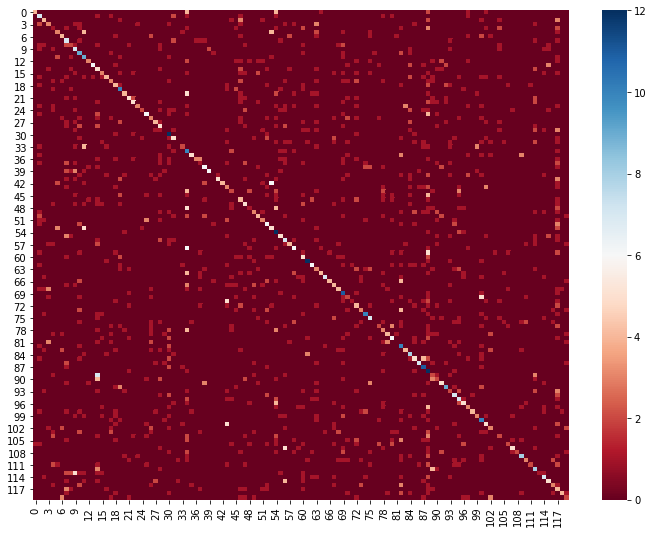

In [13]:
plt.figure(figsize=(12,9))
sns.heatmap(data = conf,cmap='RdBu')

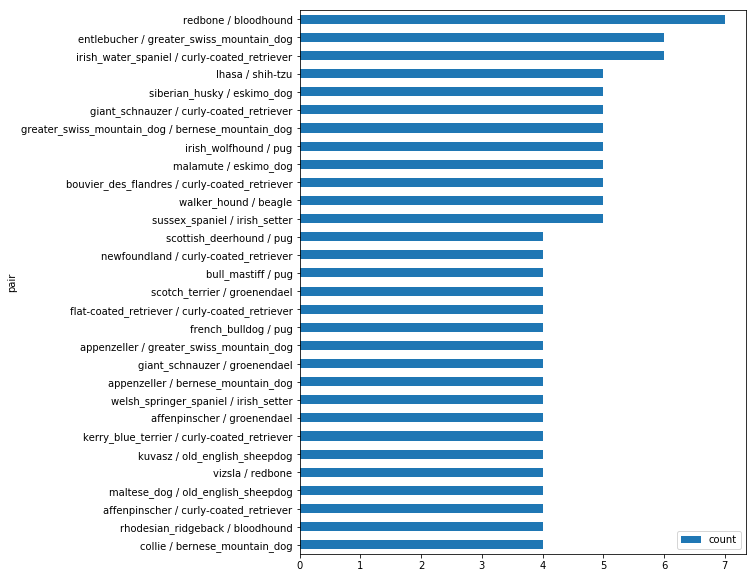

In [14]:
import pandas as pd

labelNames = [target_names[x] for x in test_generator.classes]
ClassPredictionsNames = [target_names[x] for x in ClassPredictions]

d = {'actual':labelNames , 'pred':ClassPredictionsNames}
df = pd.DataFrame(d)

df['count'] = 1

misclass_df = df[df['actual'] != df['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()

misclass_df['pair'] = misclass_df['actual'].astype(str) + ' / ' + misclass_df['pred'].astype(str)

misclass_df = misclass_df[['pair', 'count']].take(range(30))

misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x='pair')

We see that the biggest mismatch is Redbone and Blood hound, the second is Greater Swiss Mountain Dog and Entlebucher.

We noticed that the first mismatch is between breeds that a human being will be able to separate. Therefore, we conlclude that our model is not performing very well, and there are still more features to learn.

The second mismatch is between breeds which are very similar and most of the humans wont distinguish between them, so maybe our model is not so bad after all.

Here are pictures of the spoken dogos:

## redbone:

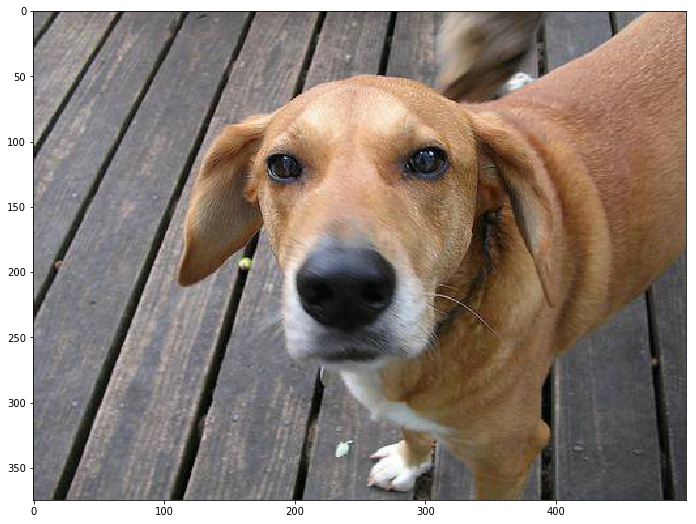

In [18]:
plt.figure(figsize=(12,9))
img=mpimg.imread('../DogBreedDataSet/valid/redbone/b220bfa6780f5e36871117680bed8b03.jpg')
imgplot = plt.imshow(img)
plt.show()

## bloodhound:

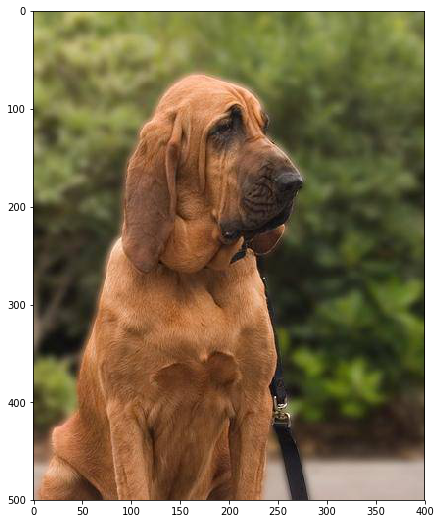

In [23]:
plt.figure(figsize=(12,9))
img=mpimg.imread('../DogBreedDataSet/train/bloodhound/593991d6febd36e8b0c0730c93768d5a.jpg')
imgplot = plt.imshow(img)
plt.show()

## Entlebucher:

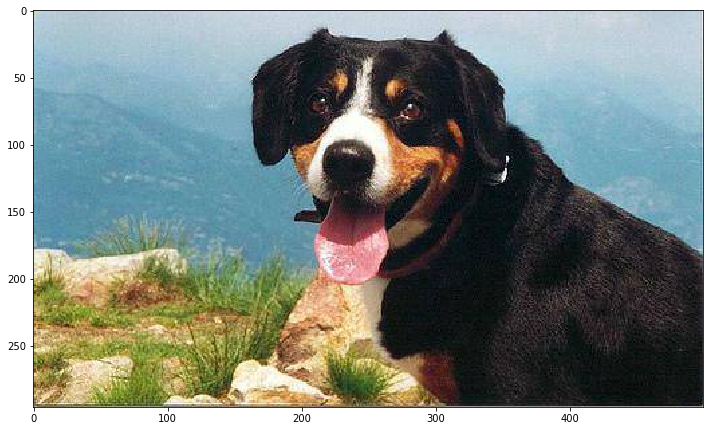

In [24]:
plt.figure(figsize=(12,9))
img=mpim## bloodhound:g.imread('../DogBreedDataSet/train/entlebucher/3a896e59b44a11f008113c6c8fd1cd7b.jpg')
imgplot = plt.imshow(img)
plt.show()

## Greater Swiss Mountain Dog:

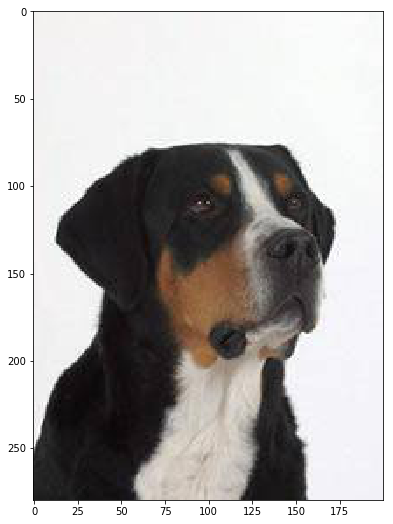

In [25]:
plt.figure(figsize=(12## entlebucher:,9))
img=mpimg.imread('../DogBreedDataSet/train/greater_swiss_mountain_dog/0177a92a906192bfde8adbb8a237e524.jpg')
imgplot = plt.imshow(img)
plt.show()

## Trying to figure out where & why is the model misclassifying and suggesting ways to improve the results:

Lose a layer in order to to have a more generelized model:
We get a lot parameters in the model, while the dataset contains about 10000 images. Even after augmenting the images and increasing the dataset size, the model has relatively high amount of parameters. Decreasing this amount will lead us to a more generilized model. We can try this by losing a conv layer.

-Clean validation:
We see that we get lower results for the validation set. Perhaps, the images in this set are not clean, and we should ensure the data is suitable.

-Lose bias in data:
We see that there is a significant difference in the amount of images there are per classes: there is a class with about 120 images, and on the other hand there is another class with just 60-70 images. 
This difference add unnatural bias to our model as the date is not balanced vey well: as we have more images of a specific class, we may classidy more images to this class just baecause there is more data in that class. 

-Bigger batches:
We strated at batch size of 20 and we saw that it 
We used image generator for images by Keras. We created 20 augmented images out of each image in order to increase out Dataset. We used the 'flow from directory' generator which made this proccess more efficient for the GPU. 
We saw that the result were not so great, so we decided to increase the batch size to 30, 40 and 50. We saw an imporvment in the results that we got.

-Image size:
We also tried changing the image size (power of 2). We saw an improvement in the training speed and eventualy chose the size of 224X224 which showed the best results.

-Dropouts:
We see that our model is overfitting as the accuracy of the training dataset is 80% but the accuracy of the validation datatset is only about 25-30%. We know that dropouts may help with the overfitting problem by making the model's weights more robust for the generalized problem.

-Clean data:
Most of the images show the dogs in defferent scales and resolutions. They also contain clutter and noise such as trees, humans, and various items in the background. This may harm the abbility of the model to perform a quality training. 
We may try and solve it by manualy going over the images and exluding the ones that conatin a lot of noise and will not contribute to the learning proccess. 

-Normalization:
Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate). Currently we just rescaled the samples by 255 to set the data values between 0 and 1. In order to make the model converge faster, we would like to set the mean of the data to 0, and standart deviation of 1. We can do that by substructing the mean pixel from the dataset, and deviding by the standart deviation. Subtracting the mean centers the input to 0, and dividing by the standard deviation makes any scaled feature value the number of standard deviations away from the mean.


d. We decided to prioritize and implement the following suggestions:

Dropouts and Normalization.

## Repeating section b:

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint

import keras.backend as K
K.set_image_data_format('channels_last')

# dimensions of our images.
img_width, img_height = 224,224


train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
nb_train_samples = 8178
nb_validation_samples = 2044

batch_size = 20

input_shape = (img_width, img_height, 3)
    
print("input_shape:",input_shape)

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5)) 

model.add(Dense(120, activation='softmax'))

model.summary()

Using TensorFlow backend.


input_shape: (224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)  

In [2]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest', 
)

# for validation we will use only rescaling
test_datagen = ImageDataGenerator(featurewise_center=True,
        featurewise_std_normalization=True)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

from time import gmtime, strftime
time = strftime("%Y.%m.%d.%H%M%S", gmtime())

tensor_board = TensorBoard(f'./logs/DogBreedScratchAnnDropouts{time}')

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5', 
                               verbose=1, save_best_only=True)


Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [3]:
epochs = 140

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/140
408/408 [==============================] - 180s 441ms/step - loss: 4.8484 - acc: 0.0207 - val_loss: 4.6158 - val_acc: 0.0387

Epoch 00001: val_loss improved from inf to 4.61583, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 2/140
408/408 [==============================] - 213s 521ms/step - loss: 4.5676 - acc: 0.0399 - val_loss: 4.4495 - val_acc: 0.0504

Epoch 00002: val_loss improved from 4.61583 to 4.44951, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 3/140
408/408 [==============================] - 172s 421ms/step - loss: 4.4204 - acc: 0.0483 - val_loss: 4.3108 - val_acc: 0.0548

Epoch 00003: val_loss improved from 4.44951 to 4.31079, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 4/140
408/408 [==============================] - 165s 406ms/step - loss: 4.2726 - acc: 0.0624 - val_loss: 4.1982 - val_acc: 0.0741

Epoch 00004: val_loss improved from 4.31079 to 4.19818, saving model to sa

408/408 [==============================] - 184s 451ms/step - loss: 2.6515 - acc: 0.3222 - val_loss: 3.0263 - val_acc: 0.2747

Epoch 00036: val_loss improved from 3.03217 to 3.02630, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 37/140
408/408 [==============================] - 166s 407ms/step - loss: 2.6130 - acc: 0.3341 - val_loss: 3.2783 - val_acc: 0.2624

Epoch 00037: val_loss did not improve from 3.02630
Epoch 38/140
408/408 [==============================] - 176s 431ms/step - loss: 2.6314 - acc: 0.3308 - val_loss: 3.0839 - val_acc: 0.2693

Epoch 00038: val_loss did not improve from 3.02630
Epoch 39/140
408/408 [==============================] - 193s 473ms/step - loss: 2.5783 - acc: 0.3437 - val_loss: 2.9538 - val_acc: 0.2950

Epoch 00039: val_loss improved from 3.02630 to 2.95384, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 40/140
408/408 [==============================] - 177s 433ms/step - loss: 2.5692 - acc: 0.3487 - 

408/408 [==============================] - 161s 394ms/step - loss: 1.8678 - acc: 0.5017 - val_loss: 2.7357 - val_acc: 0.3617

Epoch 00119: val_loss did not improve from 2.64842
Epoch 120/140
408/408 [==============================] - 160s 391ms/step - loss: 1.8762 - acc: 0.4961 - val_loss: 2.7933 - val_acc: 0.3597

Epoch 00120: val_loss did not improve from 2.64842
Epoch 121/140
408/408 [==============================] - 161s 395ms/step - loss: 1.8763 - acc: 0.4952 - val_loss: 2.7606 - val_acc: 0.3503

Epoch 00121: val_loss did not improve from 2.64842
Epoch 122/140
408/408 [==============================] - 160s 392ms/step - loss: 1.8535 - acc: 0.5020 - val_loss: 2.7461 - val_acc: 0.3567

Epoch 00122: val_loss did not improve from 2.64842
Epoch 123/140
408/408 [==============================] - 160s 393ms/step - loss: 1.8766 - acc: 0.4899 - val_loss: 2.8031 - val_acc: 0.3671

Epoch 00123: val_loss did not improve from 2.64842
Epoch 124/140
408/408 [==============================] - 16

## A few words about the improvement:

After adding dropouts and normalizing better, we saw an improvement – we managed to get a 37% accuracy score on the validation set and val_loss of 2.7393 which is not good but still an improvment from 2.88684.
Maybe adding another dense layer and another dropuot layer before our softmax classification layer could help reduce val_loss more and make our model more generalized.

# Part 3

We decided to chose the Xception trained model architecture from Keras. 

Xception is an extension of the Inception architecture which replaces the standard Inception modules with depthwise separable convolutions.
Xception sports the smallest weight serialization at only 91MB (vgg16/19 have weights are > 500MB). This is a huge benefit as we have limited computing resources at hand. 
Xception require 299×299 pixel inputs.


a. Changing the last layer to correspond to the task at hand:

After a couple of runs we decided to add the GlobalAveragePooling, Dropout, Dense (fully connected).

-Global average pooling replaces the traditional fully connected layers in CNN. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer. 
It treats the convolutional layers as feature extractors, and the resulting feature is classified in a traditional way. 
Advantages:
There is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. 
It is also more native to the convolution structure by enforcing correspondences between feature maps and categories.

-Dropout is a technique used to improve over-fit on neural networks.
The use of dropout also make the training loss error a little worse. But that's the idea, basically we want to trade training performance for more generalization.
Normally we would like to use Dropout on the fully connected layers, but is also possible to use dropout after the average/max-pooling layers, creating some kind of image noise augmentation.

-Dense (fully connected) layers perform classification on the features, extracted by the convolutional layers, and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

As Xception was trained with images of size 299x299, we will resize the Dataset and will convert all the images to that size. We chose to use the same augmenation as in Part 2 since we work with the same Dataset and we saw that it improved the results. 

# Creating a New Model:

In [79]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception


# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [80]:
from Scripts.clr_callback import CyclicLR

import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard

from time import gmtime, strftime


# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=10)
time = strftime("%Y.%m.%d.%H%M%S", gmtime())


# model_checkpoint = ModelCheckpoint(bst_model_path,
#                                    save_best_only=True,
#                                    save_weights_only=True)

checkpointer = ModelCheckpoint(filepath=f'saved_models/{time}_dog_breed_model.hdf5', 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_acc'
                              )

tensor_board = TensorBoard(f'./logs/DogBreedAnn{time}')

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)


In [81]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Fitting the new model:

In [82]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
# dimensions of our images.
img_width, img_height = 299,299
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocess_input
)

# for validation we will use only rescaling
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# min sd for normalising

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [16]:
nb_train_samples = 8178
nb_validation_samples = 2044
epochs = 50

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   



Epoch 1/50
511/511 [==============================] - 627s 1s/step - loss: 2.7496 - acc: 0.4075 - val_loss: 0.5679 - val_acc: 0.8297

Epoch 00001: val_acc improved from -inf to 0.82972, saving model to saved_models/2018.11.23.225348_dog_breed_model.hdf5
Epoch 2/50
511/511 [==============================] - 622s 1s/step - loss: 1.1000 - acc: 0.6974 - val_loss: 0.4600 - val_acc: 0.8516

Epoch 00002: val_acc improved from 0.82972 to 0.85158, saving model to saved_models/2018.11.23.225348_dog_breed_model.hdf5
Epoch 3/50
511/511 [==============================] - 621s 1s/step - loss: 1.0899 - acc: 0.7204 - val_loss: 0.5321 - val_acc: 0.8323

Epoch 00003: val_acc did not improve from 0.85158
Epoch 4/50
511/511 [==============================] - 621s 1s/step - loss: 1.1536 - acc: 0.7162 - val_loss: 0.5304 - val_acc: 0.8437

Epoch 00004: val_acc did not improve from 0.85158
Epoch 5/50
511/511 [==============================] - 622s 1s/step - loss: 1.1474 - acc: 0.7334 - val_loss: 0.4807 - val_


Epoch 00042: val_acc did not improve from 0.86686


In [84]:
# creating dataGenerator for our validation data
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= None)

#loading the model
model.load_weights('saved_models/2018.11.23.225348_dog_breed_model.hdf5')

predictions = model.predict_generator(test_generator, (nb_validation_samples // batch_size+1) )

Found 2044 images belonging to 120 classes.


## Analysis of predictions:

Lets gather some metrics and analyse it

In [117]:
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
import matplotlib.pyplot as plt

ClassPredictions = predictions.argmax(axis=-1) 
conf = confusion_matrix(test_generator.classes, ClassPredictions)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()



print(classification_report(test_generator.classes, ClassPredictions, target_names=target_names))


                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.94        17
                  afghan_hound       0.94      0.94      0.94        17
           african_hunting_dog       1.00      0.88      0.94        17
                      airedale       0.86      0.71      0.77        17
american_staffordshire_terrier       0.71      0.59      0.65        17
                   appenzeller       0.75      0.71      0.73        17
            australian_terrier       0.70      0.94      0.80        17
                       basenji       1.00      0.94      0.97        17
                        basset       0.89      1.00      0.94        17
                        beagle       0.87      0.76      0.81        17
            bedlington_terrier       0.94      1.00      0.97        17
          bernese_mountain_dog       0.77      1.00      0.87        17
       black-and-tan_coonhound       0.94      0.88      0.91  

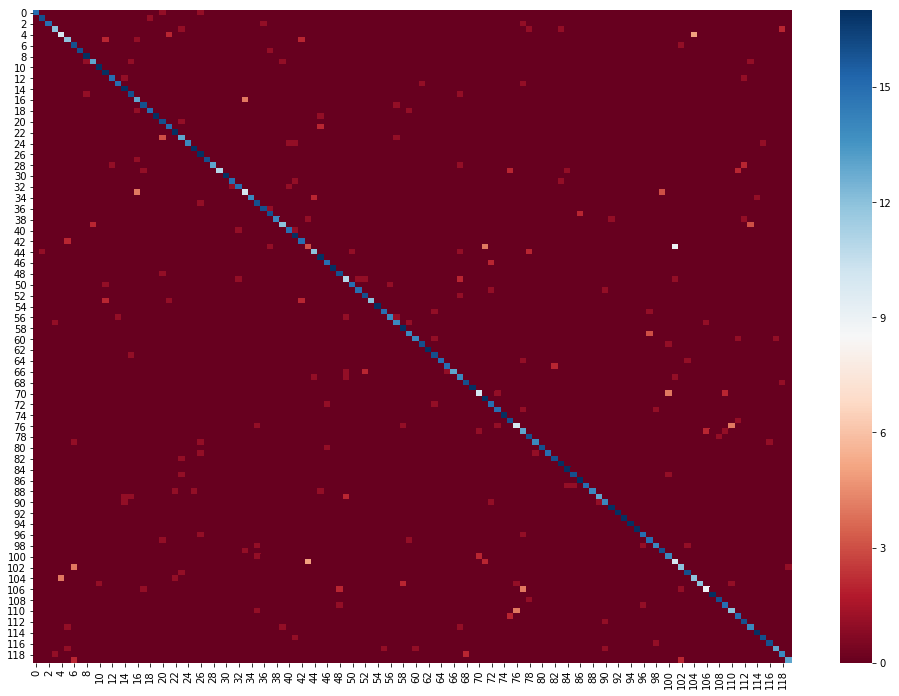

In [89]:
plt.figure(figsize=(17,12))
sns.heatmap(data = conf,cmap='RdBu')

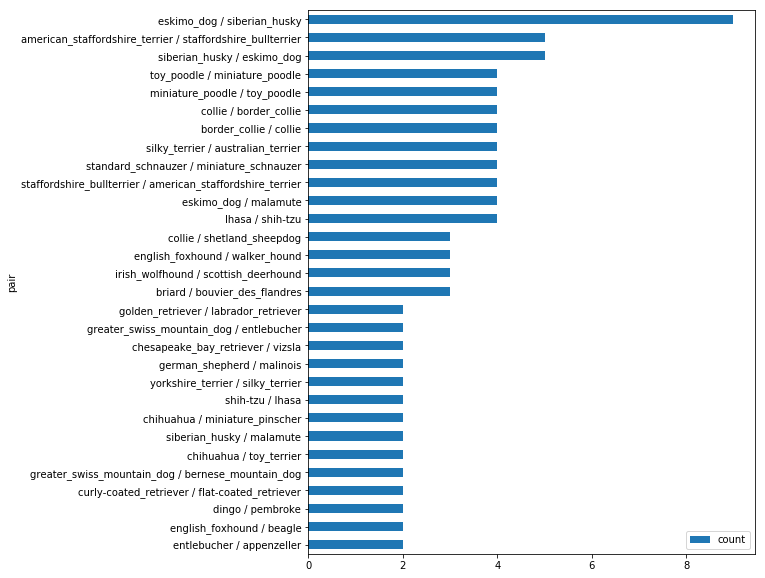

In [118]:
import pandas as pd

labelNames = [target_names[x] for x in test_generator.classes]
ClassPredictionsNames = [target_names[x] for x in ClassPredictions]

d = {'actual':labelNames , 'pred':ClassPredictionsNames}
df = pd.DataFrame(d)

df['count'] = 1

misclass_df = df[df['actual'] != df['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()

misclass_df['pair'] = misclass_df['actual'].astype(str) + ' / ' + misclass_df['pred'].astype(str)

misclass_df = misclass_df[['pair', 'count']].take(range(30))

misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x='pair')

The largest mismatch is between Siberian Husky and Eskimo Dog and the seccond biggest mismach is between American Staffordshire Terrier and Staffordshire Bullterier.

Both of the mismatches are between very similar breeds, we expect a human to misclassify them as well and have precision rate of 50%.

Another interesting key here is that the model, is having more mistakes of eskimo as husky then the opposite, this is probably due to the imbalance we have in our data as husky class has more samples than eskimo

## Siberian Husky:

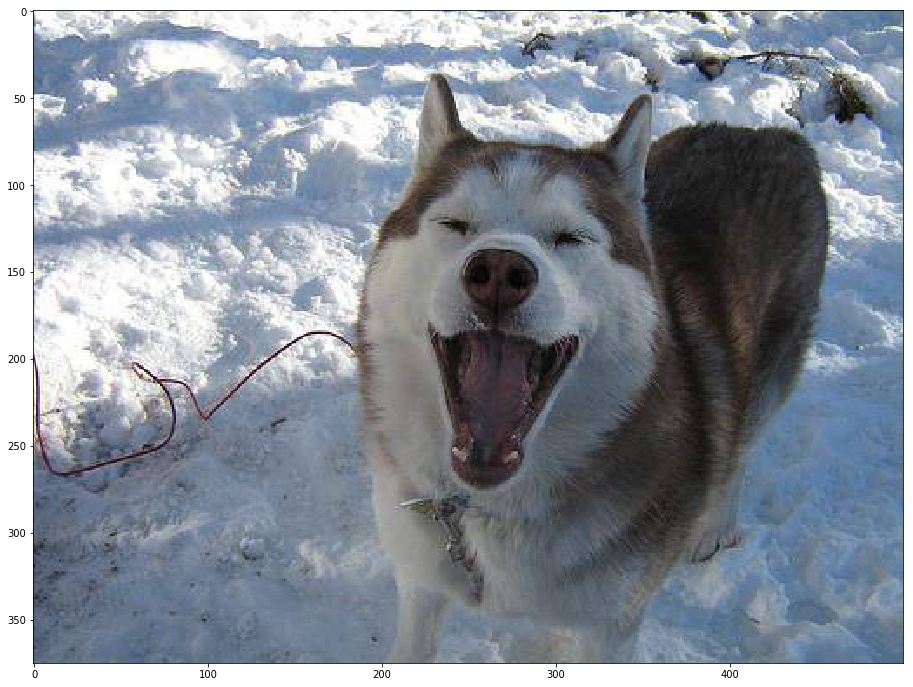

In [10]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/siberian_husky/7972d0467f6a8d6f209f948347061e24.jpg')
imgplot = plt.imshow(img)
plt.show()


## Eskimo Dog:

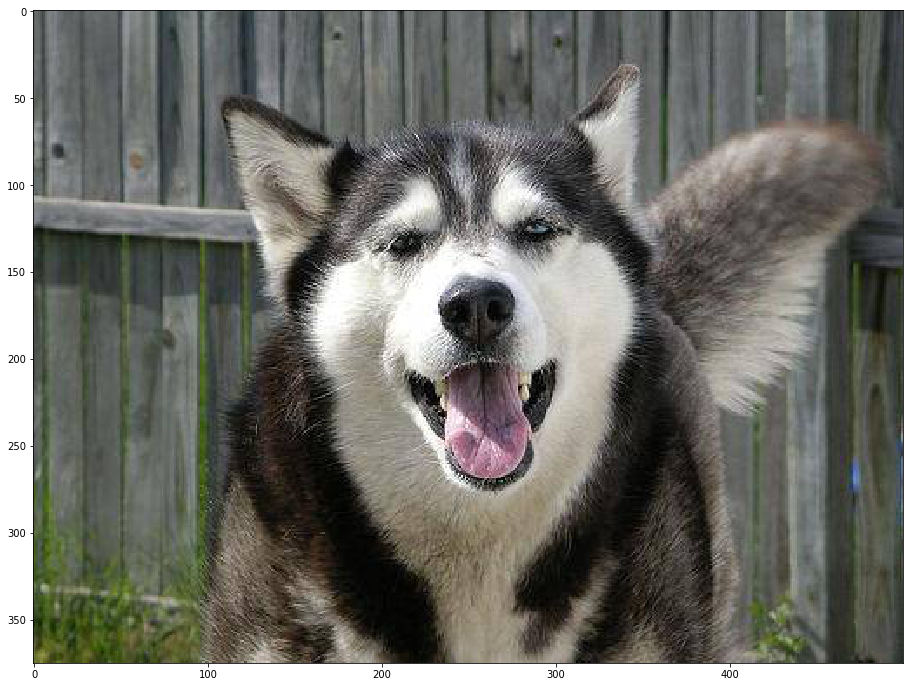

In [11]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/eskimo_dog/c9579c8fd920a1e698c696168946a83b.jpg')
imgplot = plt.imshow(img)
plt.show()


## American Staffordshire Terrier:

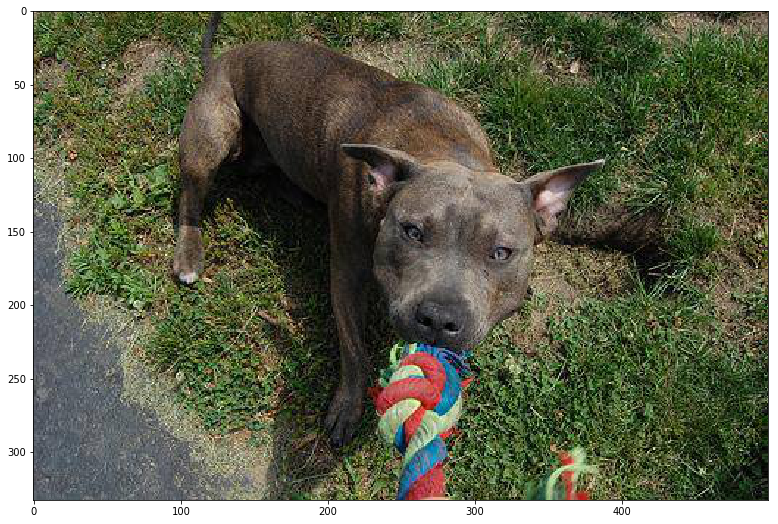

In [28]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/american_staffordshire_terrier/29bea12d15de7705ddc0e2d1d8c95f6b.jpg')
imgplot = plt.imshow(img)
plt.show()


## Staffordshire Bullterier:

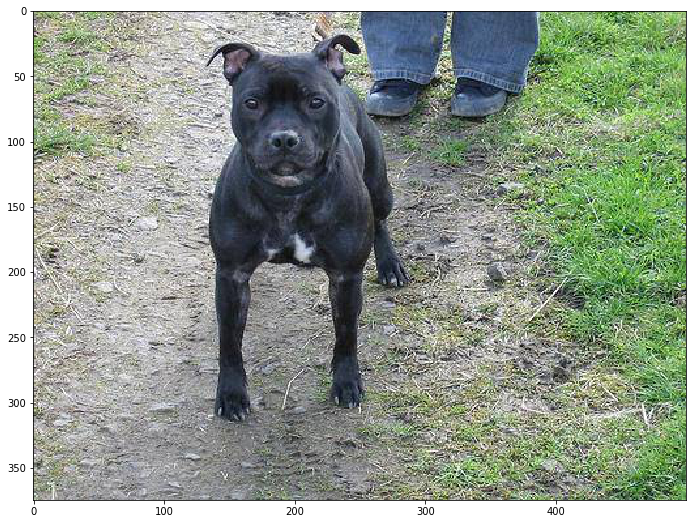

In [29]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/staffordshire_bullterrier/4b9ce080f420698deda6df4fd82240f4.jpg')
imgplot = plt.imshow(img)
plt.show()


## Extracting features:

We decided to use the Logistic regression Machine Learning algorithm. Logistic regression is one of the most famous machine learning algorithms. The use of logistic regression is for classification tasks, which is exactly our task.
We are using the previous trained model as a feature extractor; we omit the last layer, and then use predicted values as features for Logistic regression algorithm.

At the end of the document there are our tries with other ML algorithm which gave worse results

In [31]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception


# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# make average pooling layer
x = base_model.output

# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = GlobalAveragePooling2D()(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

train_data_dir = '../DogBreedDataSet/train'
validation_data_dir = '../DogBreedDataSet/valid'
# dimensions of our images.
img_width, img_height = 299,299
batch_size = 16
nb_train_samples = 8178
nb_validation_samples = 2044

# freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
           metrics=["accuracy"])

# for validation we will use only preproccesing of xception
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)


# creating dataGenerator for our training data
MLTrain_generator = test_datagen.flow_from_directory(
    train_data_dir,
    shuffle=False,
    class_mode=None,
    target_size=(img_width, img_height),
    batch_size=1)

MLTest_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    class_mode=None,
    target_size=(img_width, img_height),
    batch_size=1)

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [33]:
MLTrain_generator.reset()
trainFeatures = model.predict_generator(MLTrain_generator, nb_train_samples )

MLTest_generator.reset()
validFeatures = model.predict_generator(MLTest_generator, nb_validation_samples )

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

logisticRegression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logisticRegression.fit(trainFeatures, MLTrain_generator.classes)

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
ClassPredictions = logisticRegression.predict(validFeatures)
ClasProba = logisticRegression.predict_proba(validFeatures)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()

print('LogLoss {}'.format(log_loss(MLTest_generator.classes, ClasProba)))
print(classification_report(MLTest_generator.classes, ClassPredictions, target_names=target_names))

Validation LogLoss 0.3611394068577661
                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.94        17
                  afghan_hound       1.00      0.94      0.97        17
           african_hunting_dog       1.00      0.88      0.94        17
                      airedale       0.94      0.94      0.94        17
american_staffordshire_terrier       0.61      0.65      0.63        17
                   appenzeller       0.75      0.71      0.73        17
            australian_terrier       0.82      0.82      0.82        17
                       basenji       1.00      1.00      1.00        17
                        basset       0.94      0.94      0.94        17
                        beagle       0.88      0.82      0.85        17
            bedlington_terrier       1.00      1.00      1.00        17
          bernese_mountain_dog       0.81      1.00      0.89        17
       black-and-tan_coon

We got weighted avg of 90%! a 3% improvement, even without sophisticated hyperparameter tuning, and a very good score for the limited resources we have.


## Best For Last (sorry not really)

Another promising approach was to train our model with variety of image size from small to big instead of fixing all of them to one size.

The idea behind this method is to teach our model the big drastic features between dog breeds, and then continue learning the more gentle features on bigger pictures.

In [3]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception
from keras.applications.xception import preprocess_input

# base model as xception
base_model = xception.Xception(weights='imagenet', include_top=False)

x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# softmax layer for predictions
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)



In [4]:
from Scripts.clr_callback import CyclicLR
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from time import gmtime, strftime

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

time = strftime("%Y.%m.%d.%H%M%S", gmtime())

savedModelFilepath=f'saved_models/{time}_dog_breed_modelSmallToBig.hdf5'

checkpointer = ModelCheckpoint(filepath=savedModelFilepath, 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_loss'
                              )

tensor_board = TensorBoard(f'./logs/DogBreedAnnSmallToBig{time}')

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)


In [5]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Fitting the new model:

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
# dimensions of our images.
img_width, img_height = 128,128
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocess_input
)

# for validation we will use only preproccesing of xception
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')





Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


## Training on image size 128X128

In [7]:
nb_train_samples = 8178
nb_validation_samples = 2044
epochs = 50

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   



Epoch 1/50
511/511 [==============================] - 131s 257ms/step - loss: 5.4793 - acc: 0.0142 - val_loss: 5.1597 - val_acc: 0.1329

Epoch 00001: val_loss improved from inf to 5.15971, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 2/50
511/511 [==============================] - 127s 249ms/step - loss: 4.9551 - acc: 0.0428 - val_loss: 5.1925 - val_acc: 0.2539

Epoch 00002: val_loss did not improve from 5.15971
Epoch 3/50
511/511 [==============================] - 126s 247ms/step - loss: 4.5901 - acc: 0.0826 - val_loss: 4.8034 - val_acc: 0.3131

Epoch 00003: val_loss improved from 5.15971 to 4.80335, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 4/50
511/511 [==============================] - 126s 247ms/step - loss: 4.3326 - acc: 0.0992 - val_loss: 5.5007 - val_acc: 0.3343

Epoch 00004: val_loss did not improve from 4.80335
Epoch 5/50
511/511 [==============================] - 126s 246ms/step - loss: 4.2253 -

We see here that after a couple of epochs the model stops learing new features and start memorizing the dataset and overfit to it

## Continue Training on image size 256X256

In [8]:
img_width, img_height = 256,256
epochs = 50

#loading the model from the best weight in last run
model.load_weights(savedModelFilepath)

#re configuring all callbacks
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

checkpointer = ModelCheckpoint(filepath=savedModelFilepath, 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_loss'
                              )

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.
Epoch 1/50
511/511 [==============================] - 438s 857ms/step - loss: 2.8336 - acc: 0.3231 - val_loss: 1.0278 - val_acc: 0.7131

Epoch 00001: val_loss improved from inf to 1.02777, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 2/50
511/511 [==============================] - 437s 856ms/step - loss: 2.1169 - acc: 0.4547 - val_loss: 0.8744 - val_acc: 0.7687

Epoch 00002: val_loss improved from 1.02777 to 0.87442, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 3/50
511/511 [==============================] - 435s 852ms/step - loss: 1.9192 - acc: 0.5078 - val_loss: 0.8682 - val_acc: 0.7791

Epoch 00003: val_loss improved from 0.87442 to 0.86818, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 4/50
511/511 [==============================] - 435s 852ms/step - loss: 1.8413 - acc: 0.5301 - va

Again after a couple of epochs the model stops learing new features and start memorizing the dataset and overfit to it,
But now the results are much better 

## Continue Training on image size 299X299
Here we are setting checkpointer and early_stopping monitor to 'val_acc' as we dont mind overfitting in the last run if it will yield a better validation accuaracy result

In [9]:
img_width, img_height = 299,299
epochs = 50

#loading the model
model.load_weights(savedModelFilepath)

clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

checkpointer = ModelCheckpoint(filepath=savedModelFilepath, 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_acc'
                              )

early_stopping = EarlyStopping(monitor='val_acc', patience=15)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.
Epoch 1/50
511/511 [==============================] - 633s 1s/step - loss: 1.1952 - acc: 0.6605 - val_loss: 0.4434 - val_acc: 0.8573

Epoch 00001: val_acc improved from -inf to 0.85728, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 2/50
511/511 [==============================] - 631s 1s/step - loss: 1.1317 - acc: 0.6800 - val_loss: 0.4270 - val_acc: 0.8654

Epoch 00002: val_acc improved from 0.85728 to 0.86538, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 3/50
511/511 [==============================] - 629s 1s/step - loss: 1.1360 - acc: 0.6951 - val_loss: 0.4224 - val_acc: 0.8644

Epoch 00003: val_acc did not improve from 0.86538
Epoch 4/50
511/511 [==============================] - 629s 1s/step - loss: 1.1570 - acc: 0.6934 - val_loss: 0.4215 - val_acc: 0.8664

Epoch 00004: val_acc improved from 0.86538 to 0.86637, saving m

In [10]:
# creating dataGenerator for our validation data
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= None)

#loading the model
model.load_weights(savedModelFilepath)

predictions = model.predict_generator(test_generator, (nb_validation_samples // batch_size+1) )

Found 2044 images belonging to 120 classes.


## Analysis of predictions:

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
import matplotlib.pyplot as plt

ClassPredictions = predictions.argmax(axis=-1) 
conf = confusion_matrix(test_generator.classes, ClassPredictions)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()



print(classification_report(test_generator.classes, ClassPredictions, target_names=target_names))


                                precision    recall  f1-score   support

                 affenpinscher       0.94      0.88      0.91        17
                  afghan_hound       1.00      0.94      0.97        17
           african_hunting_dog       0.88      0.88      0.88        17
                      airedale       0.89      1.00      0.94        17
american_staffordshire_terrier       0.70      0.82      0.76        17
                   appenzeller       0.77      0.59      0.67        17
            australian_terrier       0.83      0.88      0.86        17
                       basenji       1.00      0.94      0.97        17
                        basset       0.94      1.00      0.97        17
                        beagle       0.81      0.76      0.79        17
            bedlington_terrier       0.89      1.00      0.94        17
          bernese_mountain_dog       0.77      1.00      0.87        17
       black-and-tan_coonhound       1.00      0.88      0.94  

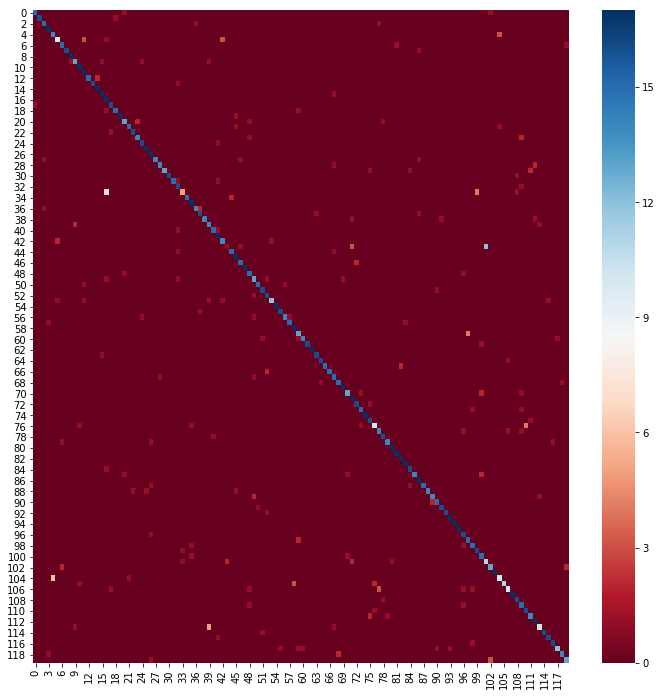

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(data = conf,cmap='RdBu')

This Method without too much epochs gave us better accuracy then running with fixed sized images.
We think that if our dataset was completely unseen (ecxeption is already trained on this data with fixed size images) we could gain even more improvments working like that

Another idea could be instead of augmenting all images to different sizes and working with them, just divide the data by sizes and train each time on larger images, but for that idea to work our dataset should be big enough to support that division

## A couple of tries with other ML algorithms

In [65]:
from sklearn.svm import SVC


svm_model_linear = SVC(C=1.0, kernel='poly', degree=7, gamma='auto').fit(trainFeatures, MLTrain_generator.classes) 

ClassPredictions = svm_model_linear.predict(validFeatures)
#ClasProba = svm_model_linear.predict_proba(validFeatures)

In [66]:
print('Validation LogLoss {}'.format(log_loss(MLTest_generator.classes, ClasProba)))
print(classification_report(MLTest_generator.classes, ClassPredictions, target_names=target_names))

Validation LogLoss 1.460287614811982
                                precision    recall  f1-score   support

                 affenpinscher       0.00      0.00      0.00        17
                  afghan_hound       0.00      0.00      0.00        17
           african_hunting_dog       0.00      0.00      0.00        17
                      airedale       0.00      0.00      0.00        17
american_staffordshire_terrier       0.00      0.00      0.00        17
                   appenzeller       0.00      0.00      0.00        17
            australian_terrier       0.00      0.00      0.00        17
                       basenji       0.00      0.00      0.00        17
                        basset       0.00      0.00      0.00        17
                        beagle       0.00      0.00      0.00        17
            bedlington_terrier       0.00      0.00      0.00        17
          bernese_mountain_dog       0.00      0.00      0.00        17
       black-and-tan_coonh

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(trainFeatures, MLTrain_generator.classes)

ClassPredictions = knn.predict(validFeatures)
ClasProba = knn.predict_proba(validFeatures)

In [60]:
ClassPredictions = knn.predict(validFeatures)
ClasProba = knn.predict_proba(validFeatures)

print('LogLoss {}'.format(log_loss(MLTest_generator.classes, ClasProba)))
print(classification_report(MLTest_generator.classes, ClassPredictions, target_names=target_names))

Validation LogLoss 1.460287614811982
                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.94        17
                  afghan_hound       0.94      0.94      0.94        17
           african_hunting_dog       1.00      0.94      0.97        17
                      airedale       0.81      1.00      0.89        17
american_staffordshire_terrier       0.69      0.65      0.67        17
                   appenzeller       0.75      0.53      0.62        17
            australian_terrier       0.70      0.94      0.80        17
                       basenji       1.00      1.00      1.00        17
                        basset       0.85      1.00      0.92        17
                        beagle       0.76      0.76      0.76        17
            bedlington_terrier       0.89      1.00      0.94        17
          bernese_mountain_dog       0.74      1.00      0.85        17
       black-and-tan_coonh